In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 150
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
import lightning as L
import captum
from captum.attr import IntegratedGradients, GuidedGradCam, Saliency
from captum.attr import visualization as viz

# from Definitions_CIFAR10
from Definitions_CIFAR10 import T, DATA_PATH, MODELS_PATH, FIGURES_PATH, NUM_CLASSES, RANDOM_SEED
from Definitions_CIFAR10 import TEACHER_TO_STUDENTS
from Definitions_CIFAR10 import NORMALIZE_MEAN, NORMALIZE_STD
from Definitions_CIFAR10 import FullNetwork, ReducedNetwork
from Definitions_CIFAR10 import TeacherModel, StudentModel
from Definitions_CIFAR10 import parse_teacher_str, parse_student_str
from Definitions_CIFAR10 import recover_trained_weights
from Definitions_CIFAR10 import get_CIFAR10_loaders, denormalize_imgs
print(f"T = {T}")
print(f"RANDOM_SEED = {RANDOM_SEED}")

# seeding
L.seed_everything(RANDOM_SEED, workers=True)
torch.manual_seed(RANDOM_SEED)

# device info
device = torch.device("cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
print(f"device = {device}")

Seed set to 42


T = 20
RANDOM_SEED = 42
device = mps


<font size=7><b>CPSC471 Project: Explainability Evaluation (CIFAR10)</b></font>

**Ruomu (Felix) Zou**

Here we evaluate the explainability of all the teacher/student networks and how close the student attributes are to the teachers.

**Model naming conventions:**
* `{F,R}T_temp{1,T}`: The *{full (larger architecture), reduced (smaller architecture)}* teacher model trained with cross-entropy with softmax temperature *{$1$, $T$ ($T>1$)}*. NOTE: Soft labels are ALWAYS generated with temperatuer $T$ regardless of teacher training temperature.
* `{F,R}S_temp{1,T}_from_{F,R}T_temp{1,T}`: Given a *{full, reduced}* teacher model trained at temperature *{$1$, $T$}*, generate soft labels at temperature $T$ and train a *{full, reduced}* student model at temperature *{$1$, $T$}*.
* Examples:
    * `FS_tempT_from_FT_tempT` represents the student model of the DD paper.
    * `RS_tempT_from_FT_temp1` represents the student model of traditional (Hinton) knowledge distillation.
    * `{F,R}S_temp1_from_{F,R}T_temp1` represents distillation where the only application of temperature is during soft label generation.
    * `{F,R}S_temp1_from_{F,R}T_tempT` represents something unconventional and weird.

# Constants and Configurations:

In [2]:
# inference-specific constants and configurations
BATCH_SIZE = 100

method_to_name = {
    IntegratedGradients: "Integrated Gradients",
    GuidedGradCam: "Grad-CAM",
    Saliency: "Saliency Map"
}

method_to_name_reduced = {
    IntegratedGradients: "IG",
    GuidedGradCam: "GradCAM",
    Saliency: "Saliency"
}

# Helper Functions:

In [39]:
def plot_attribution_on_ax(ax, model_str, attribution_method_class, image_idx, dataloader, just_relevant=False, original_image=False,):
    """Plot given attribution image on axis.

    NOTE: Assumes that the model corresponding to the passed string has been trained and saved already!

    Args:
        ax: matpotlib axis to plot on.
        model_str: str representing the model.
        attribution_method_class: captum.attr attribution class.
        image_idx: int, index of the image to attack and plot.
        dataloader: dataloader from which to draw attack images.
        just_relevant: bool, just display the pixels that have large attributions.
        original_image: bool, whether to show the original image.
    Returns:
        None.
    """
    # recover weights
    network = recover_trained_weights(model_str)

    # get image to attribute
    img, label = dataloader.dataset[image_idx]
    img = img.unsqueeze(0) # captum wants batch format for images
    label_name = trainloader.dataset.classes[label]

    # get prediction for image
    pred = network(img).argmax(-1).item()
    pred_name = trainloader.dataset.classes[pred]

    # get captum object
    if attribution_method_class is GuidedGradCam:
        attributor = attribution_method_class(network, network.convblock2) # both full/reduced networks have convblock2
    else:
        attributor = attribution_method_class(network)

    # generate attribution and plot
    attributions = attributor.attribute(img, target=label)
    attributions = attributions.squeeze().permute(1,2,0).detach().numpy()
    if original_image:
        ax.set_title(f"Original Image {image_idx} with Label '{label_name}' (Prediction '{pred_name}')", fontsize=6)
        viz.visualize_image_attr(attributions,
                                 original_image=denormalize_imgs(img).squeeze().permute(1,2,0).numpy(),
                                 method="original_image",
                                 plt_fig_axis=(ax.get_figure(), ax),
                                 use_pyplot=False)
    else:
        ax.set_title(f"{model_str}: {method_to_name_reduced[attribution_method_class]} on Image {image_idx} (Label '{label_name}', Pred '{pred_name}')", fontsize=6)
        viz.visualize_image_attr(attributions,
                                 original_image=denormalize_imgs(img).squeeze().permute(1,2,0).numpy(),
                                 method="alpha_scaling" if just_relevant else "blended_heat_map",
                                 sign="absolute_value",
                                 plt_fig_axis=(ax.get_figure(), ax),
                                 alpha_overlay=0.5,
                                 use_pyplot=False)

def compute_attribution_similarity(model_1_str, model_2_str, attribution_method_class, dataloader, max_batches=None):
    """Compute the cosine similarity between the attributions of two models.

    NOTE: Assumes that boths model corresponding to the passed strings have been trained and saved already!

    Args:
        model_1_str: str representing the first model.
        model_2_str: str representing the second model.
        attribution_method_class: captum.attr attribution class.
        dataloader: dataloader from which to draw attack images.
        max_batches: if None, generate adversarial images for whole dataloader. Otherwise only go for
                     specified number of batches.
    Returns:
        A scalar indicating the cosine similarity.
    """
    # recover weights
    network1 = recover_trained_weights(model_1_str)
    network2 = recover_trained_weights(model_2_str)

    # get captum object
    if attribution_method_class is GuidedGradCam:
        attributor1 = attribution_method_class(network1, network1.convblock2) # both full/reduced networks have convblock2
        attributor2 = attribution_method_class(network2, network2.convblock2)
    else:
        attributor1 = attribution_method_class(network1)
        attributor2 = attribution_method_class(network2)

    # loop through and evaluate each batch
    cosine_similarities = []
    torch.manual_seed(RANDOM_SEED)
    for i, (imgs, labels) in enumerate(dataloader):
        # stop if exceeded max_batches
        if max_batches is not None and i+1 > max_batches:
            break

        # get attributions
        attributions1 = attributor1.attribute(imgs, target=labels)
        attributions2 = attributor2.attribute(imgs, target=labels)

        # flatten into arrays
        attributions1 = attributions1.flatten().detach().numpy()
        attributions2 = attributions2.flatten().detach().numpy()
    
        # compute cosine similarity and add to list
        cosine_similarity = np.dot(attributions1,attributions2) / (np.linalg.norm(attributions1)*np.linalg.norm(attributions2))
        cosine_similarities.append(cosine_similarity)

    # return the mean cosine similarity
    return sum(cosine_similarities) / len(cosine_similarities)



def compute_all_adherences(methods, dataloader, max_batches=None):
    """Wrapper for compute_attribution_similarity to run on all models."""
    # loop through all teachers
    for teacher, students in TEACHER_TO_STUDENTS.items():
        
        # first print a single line with all the model names
        print(f"{f'{teacher}:' : <20}", end="")
        for student in students:
            print(f"{f'{student}:' : <25}",end="")
        print() # newline

        # then print one line for each method
        for method in methods:
            # print placeholder string
            print(f"{'': <20}",end="")
            # assess adherence of all students to teacher
            for student in students:
                similarity = compute_attribution_similarity(student, teacher, method, dataloader, max_batches)
                print(f"{f'  * {method_to_name_reduced[method]}: {round(similarity, 3)}' : <25}",end="")
            print() # newline
        print() # newline

# Execution:

## Get data:

In [4]:
trainloader, testloader = get_CIFAR10_loaders(BATCH_SIZE)

## Evaluate adherences:

In [5]:
# compute_all_adherences([Saliency, IntegratedGradients, GuidedGradCam], testloader, max_batches=10)

RT_temp1:           RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
                      * Saliency: 0.644        * Saliency: 0.584        * Saliency: 0.661        * Saliency: 0.602      
                      * IG: 0.411              * IG: 0.371              * IG: 0.485              * IG: 0.412            
                      * GradCAM: 0.628         * GradCAM: 0.548         * GradCAM: 0.681         * GradCAM: 0.607       

FT_temp1:           RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
                      * Saliency: 0.583        * Saliency: 0.569        * Saliency: 0.585        * Saliency: 0.572      
                      * IG: 0.266              * IG: 0.425              * IG: 0.274              * IG: 0.463            
                      * GradCAM: 0.432         * GradCAM: 0.673         * GradCAM: 0.462         * GradCAM: 0.679       

RT_tempT:           RS_temp1_f

RT_temp1:           RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
                      * Saliency: 0.644        * Saliency: 0.584        * Saliency: 0.661        * Saliency: 0.602      
                      * IG: 0.411              * IG: 0.371              * IG: 0.485              * IG: 0.412            
                      * GradCAM: 0.628         * GradCAM: 0.548         * GradCAM: 0.681         * GradCAM: 0.607       

FT_temp1:           RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
                      * Saliency: 0.583        * Saliency: 0.569        * Saliency: 0.585        * Saliency: 0.572      
                      * IG: 0.266              * IG: 0.425              * IG: 0.274              * IG: 0.463            
                      * GradCAM: 0.432         * GradCAM: 0.673         * GradCAM: 0.462         * GradCAM: 0.679       

RT_tempT:           RS_temp1_from_RT_tempT:  FS_temp1_from_RT_tempT:  RS_tempT_from_RT_tempT:  FS_tempT_from_RT_tempT:  
                      * Saliency: 0.669        * Saliency: 0.586        * Saliency: 0.71         * Saliency: 0.635      
                      * IG: 0.536              * IG: 0.394              * IG: 0.632              * IG: 0.479            
                      * GradCAM: 0.62          * GradCAM: 0.529         * GradCAM: 0.714         * GradCAM: 0.584       

FT_tempT:           RS_temp1_from_FT_tempT:  FS_temp1_from_FT_tempT:  RS_tempT_from_FT_tempT:  FS_tempT_from_FT_tempT:  
                      * Saliency: 0.575        * Saliency: 0.631        * Saliency: 0.568        * Saliency: 0.661      
                      * IG: 0.279              * IG: 0.438              * IG: 0.221              * IG: 0.505            
                      * GradCAM: 0.401         * GradCAM: 0.575         * GradCAM: 0.341         * GradCAM: 0.652  

In [6]:
# between baseline and fully DD-ed model
sal = compute_attribution_similarity("FT_temp1", "FS_tempT_from_FT_tempT", Saliency, testloader, max_batches=3)
ig = compute_attribution_similarity("FT_temp1", "FS_tempT_from_FT_tempT", IntegratedGradients, testloader, max_batches=3)
gradcam = compute_attribution_similarity("FT_temp1", "FS_tempT_from_FT_tempT", GuidedGradCam, testloader, max_batches=3)
print("Adherence of fully defensively distilled model and baseline model:")
print(f"    Cosine similarity with {method_to_name_reduced[Saliency]}: {sal}.")
print(f"    Cosine similarity with {method_to_name_reduced[IntegratedGradients]}: {ig}.")
print(f"    Cosine similarity with {method_to_name_reduced[GuidedGradCam]}: {gradcam}.")

Adherence of fully defensively distilled model and baseline model:
    Cosine similarity with Saliency: 0.616205096244812.
    Cosine similarity with IG: 0.40997089969376505.
    Cosine similarity with GradCAM: 0.5889777938524882.


## Single image examples:

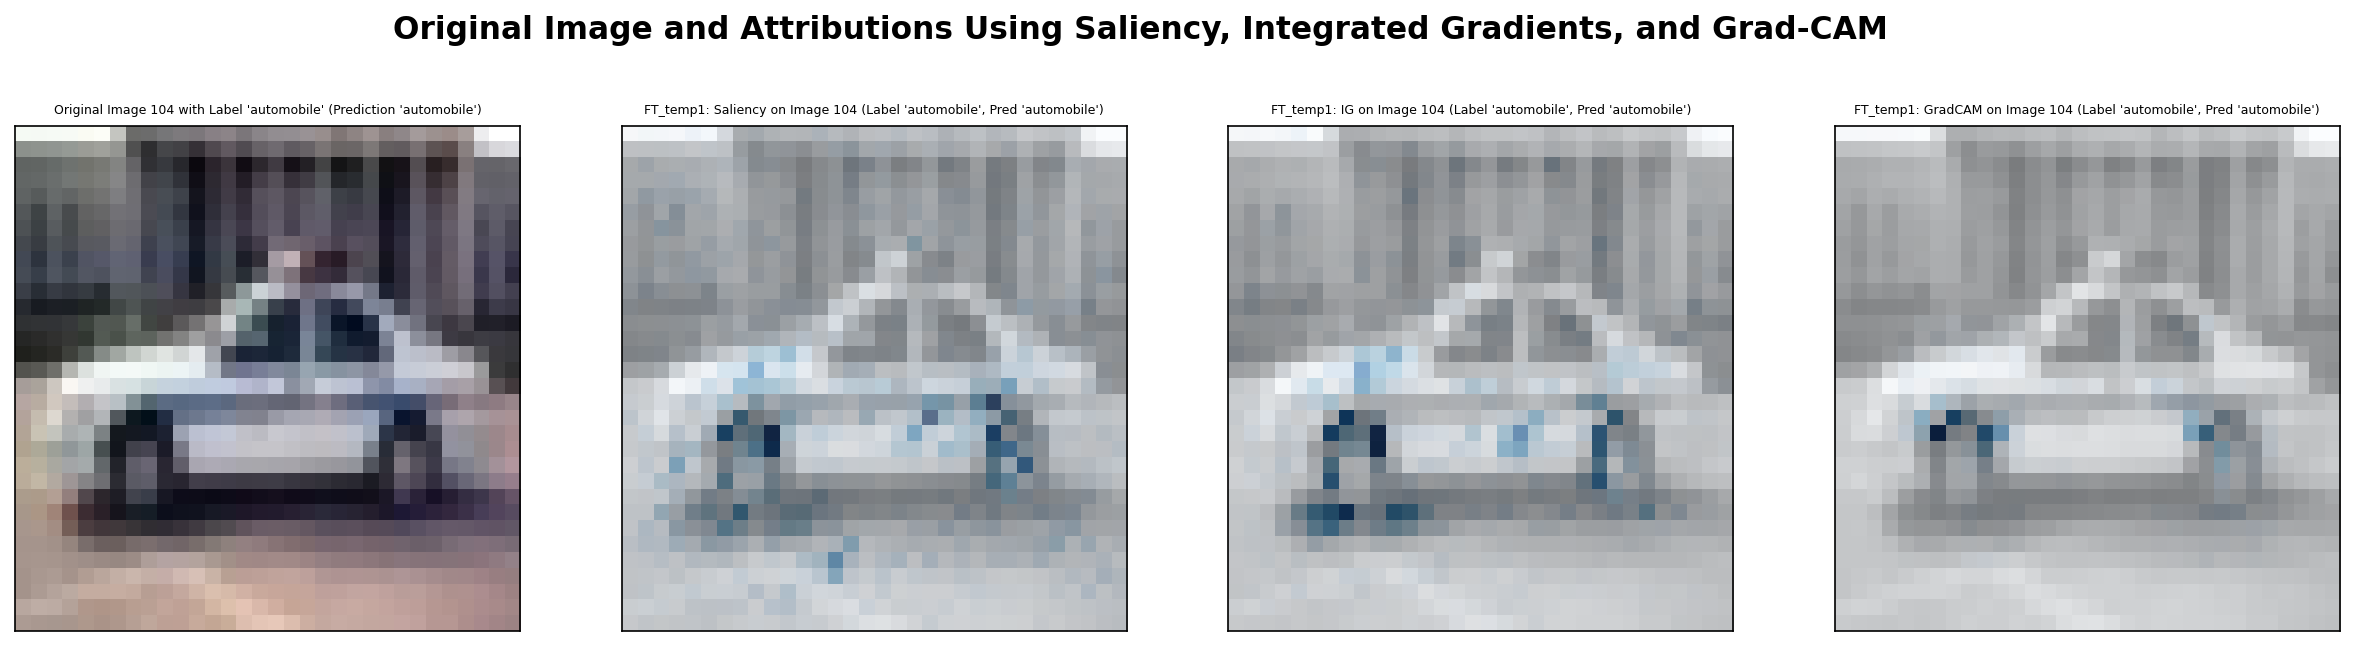

In [45]:
model_str = "FT_temp1"
img_idx = 104
loader = testloader
just_relevant = False

fig, ax = plt.subplots(1,4,figsize=(20,5))
plot_attribution_on_ax(ax[0], model_str, Saliency, img_idx, loader, just_relevant, original_image=True)
plot_attribution_on_ax(ax[1], model_str, Saliency, img_idx, loader, just_relevant, original_image=False)
plot_attribution_on_ax(ax[2], model_str, IntegratedGradients, img_idx, loader, just_relevant, original_image=False)
plot_attribution_on_ax(ax[3], model_str, GuidedGradCam, img_idx, loader, just_relevant, original_image=False)
plt.suptitle("Original Image and Attributions Using Saliency, Integrated Gradients, and Grad-CAM",
             fontsize=15, fontweight="bold")
plt.savefig(os.path.join(FIGURES_PATH, f"Attributions_{model_str}_img{img_idx}.png"))
plt.show()

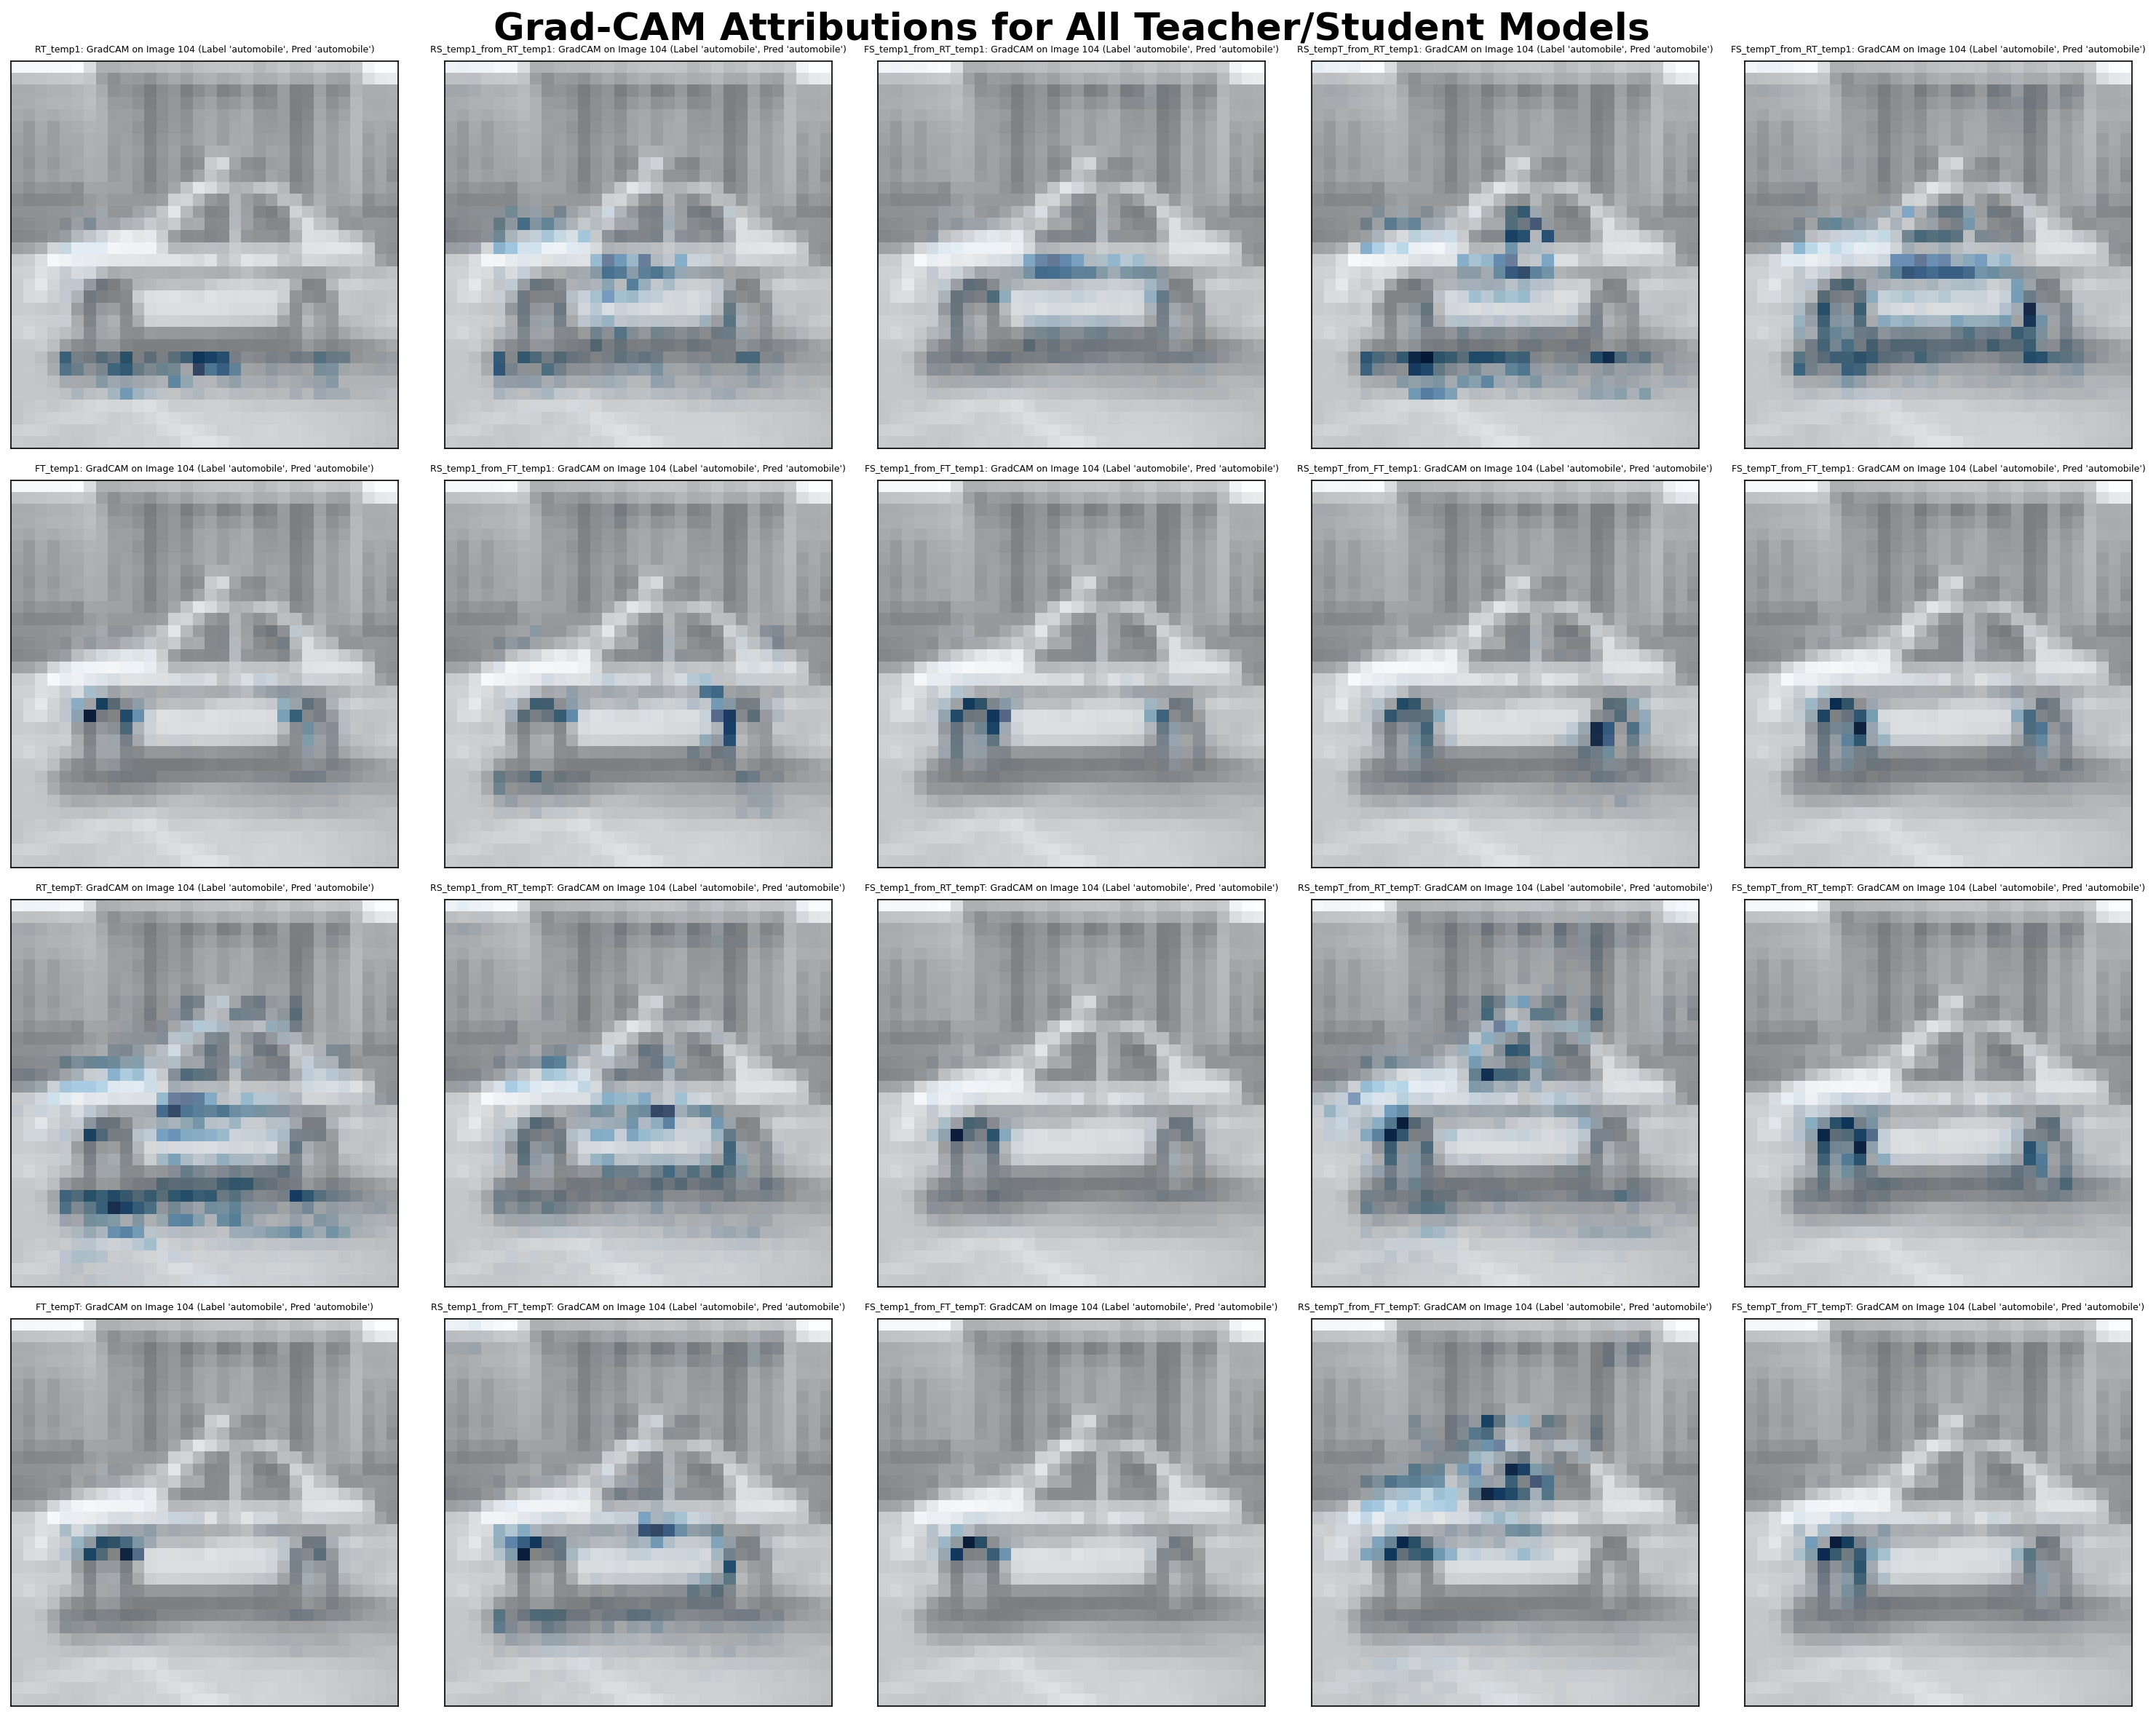

In [41]:
img_idx = 104
method = GuidedGradCam
dataloader = testloader
just_relevant = False

# create subplots
num_cols = 5
num_rows = 4
fig, ax = plt.subplots(4, 5, figsize=(4*num_cols,4*num_rows))

# populate subplots
for row, (teacher, students) in enumerate(TEACHER_TO_STUDENTS.items()):
    # first plot teacher model
    plot_attribution_on_ax(ax[row][0], teacher, method, img_idx, dataloader, just_relevant)

    # iterate through students and plot
    for col, student in enumerate(students):
        plot_attribution_on_ax(ax[row][col+1], student, method, img_idx, dataloader, just_relevant)
    
# superplot configurations
fig.suptitle(f"{method_to_name[method]} Attributions for All Teacher/Student Models", fontsize=25, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f"{method_to_name_reduced[method]}_img{img_idx}_ALL.png"))
plt.show()

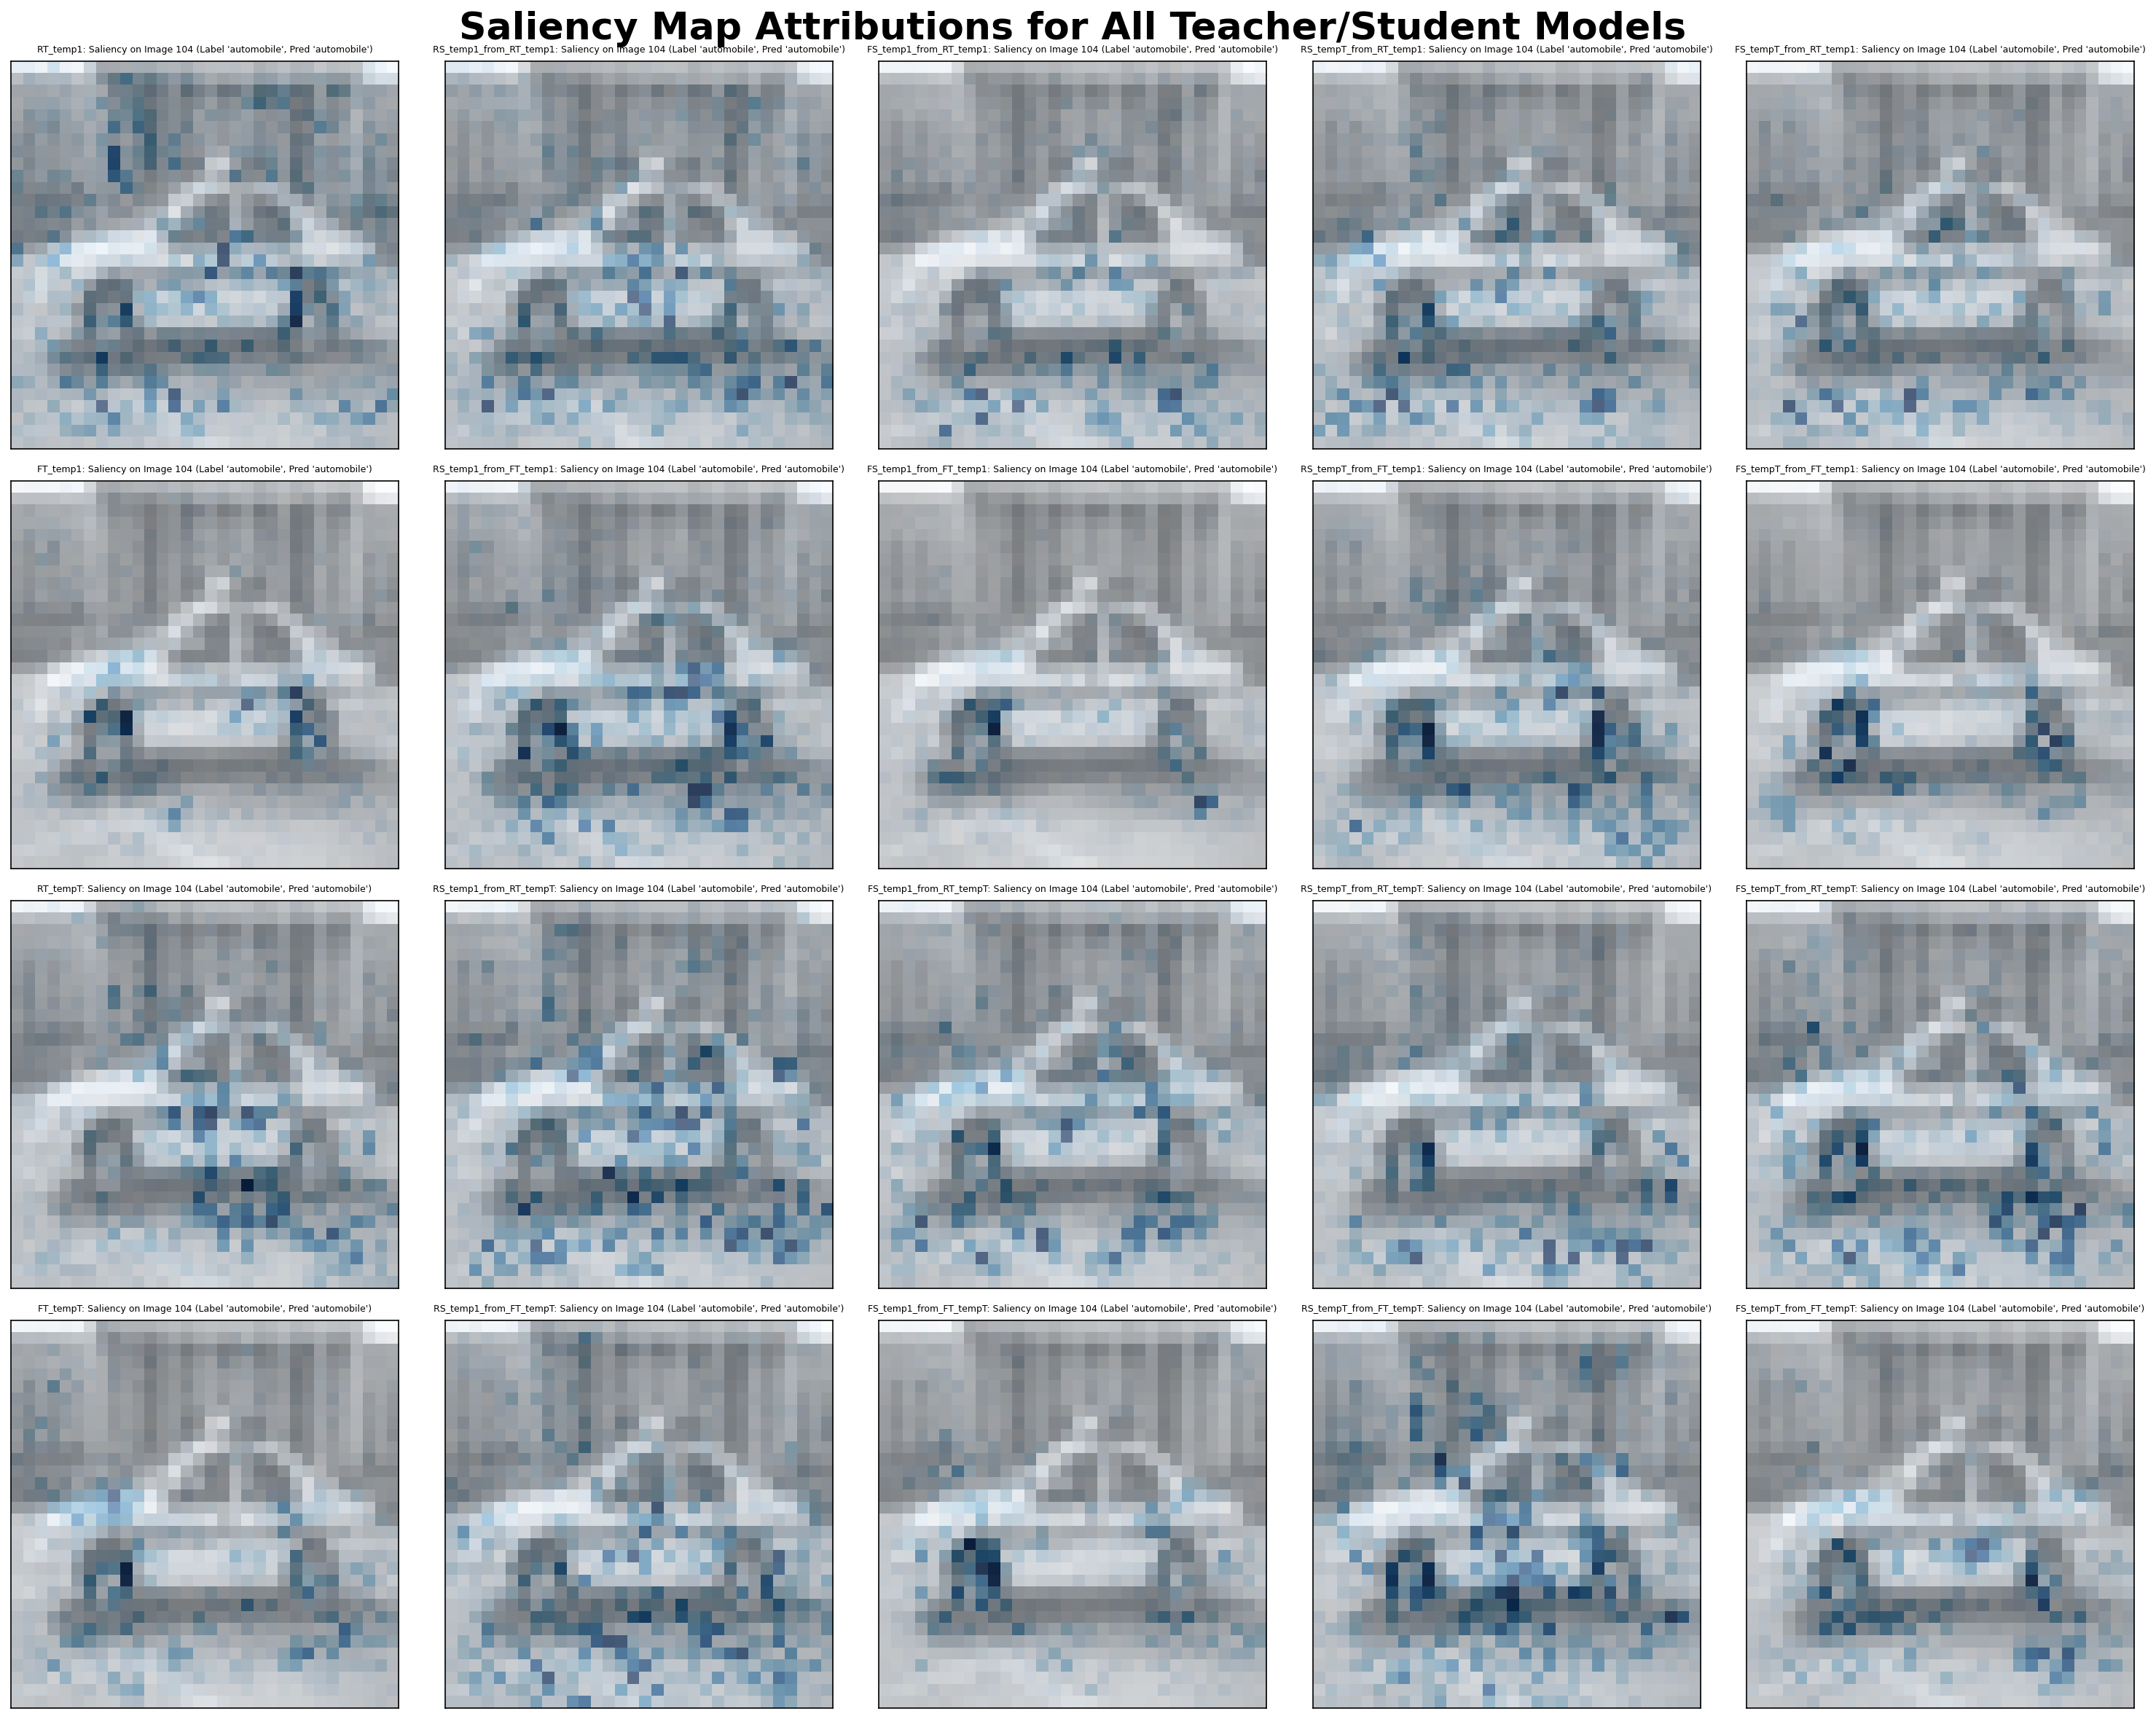

In [42]:
img_idx = 104
method = Saliency
dataloader = testloader
just_relevant = False

# create subplots
num_cols = 5
num_rows = 4
fig, ax = plt.subplots(4, 5, figsize=(4*num_cols,4*num_rows))

# populate subplots
for row, (teacher, students) in enumerate(TEACHER_TO_STUDENTS.items()):
    # first plot teacher model
    plot_attribution_on_ax(ax[row][0], teacher, method, img_idx, dataloader, just_relevant)

    # iterate through students and plot
    for col, student in enumerate(students):
        plot_attribution_on_ax(ax[row][col+1], student, method, img_idx, dataloader, just_relevant)
    
# superplot configurations
fig.suptitle(f"{method_to_name[method]} Attributions for All Teacher/Student Models", fontsize=25, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f"{method_to_name_reduced[method]}_img{img_idx}_ALL.png"))
plt.show()

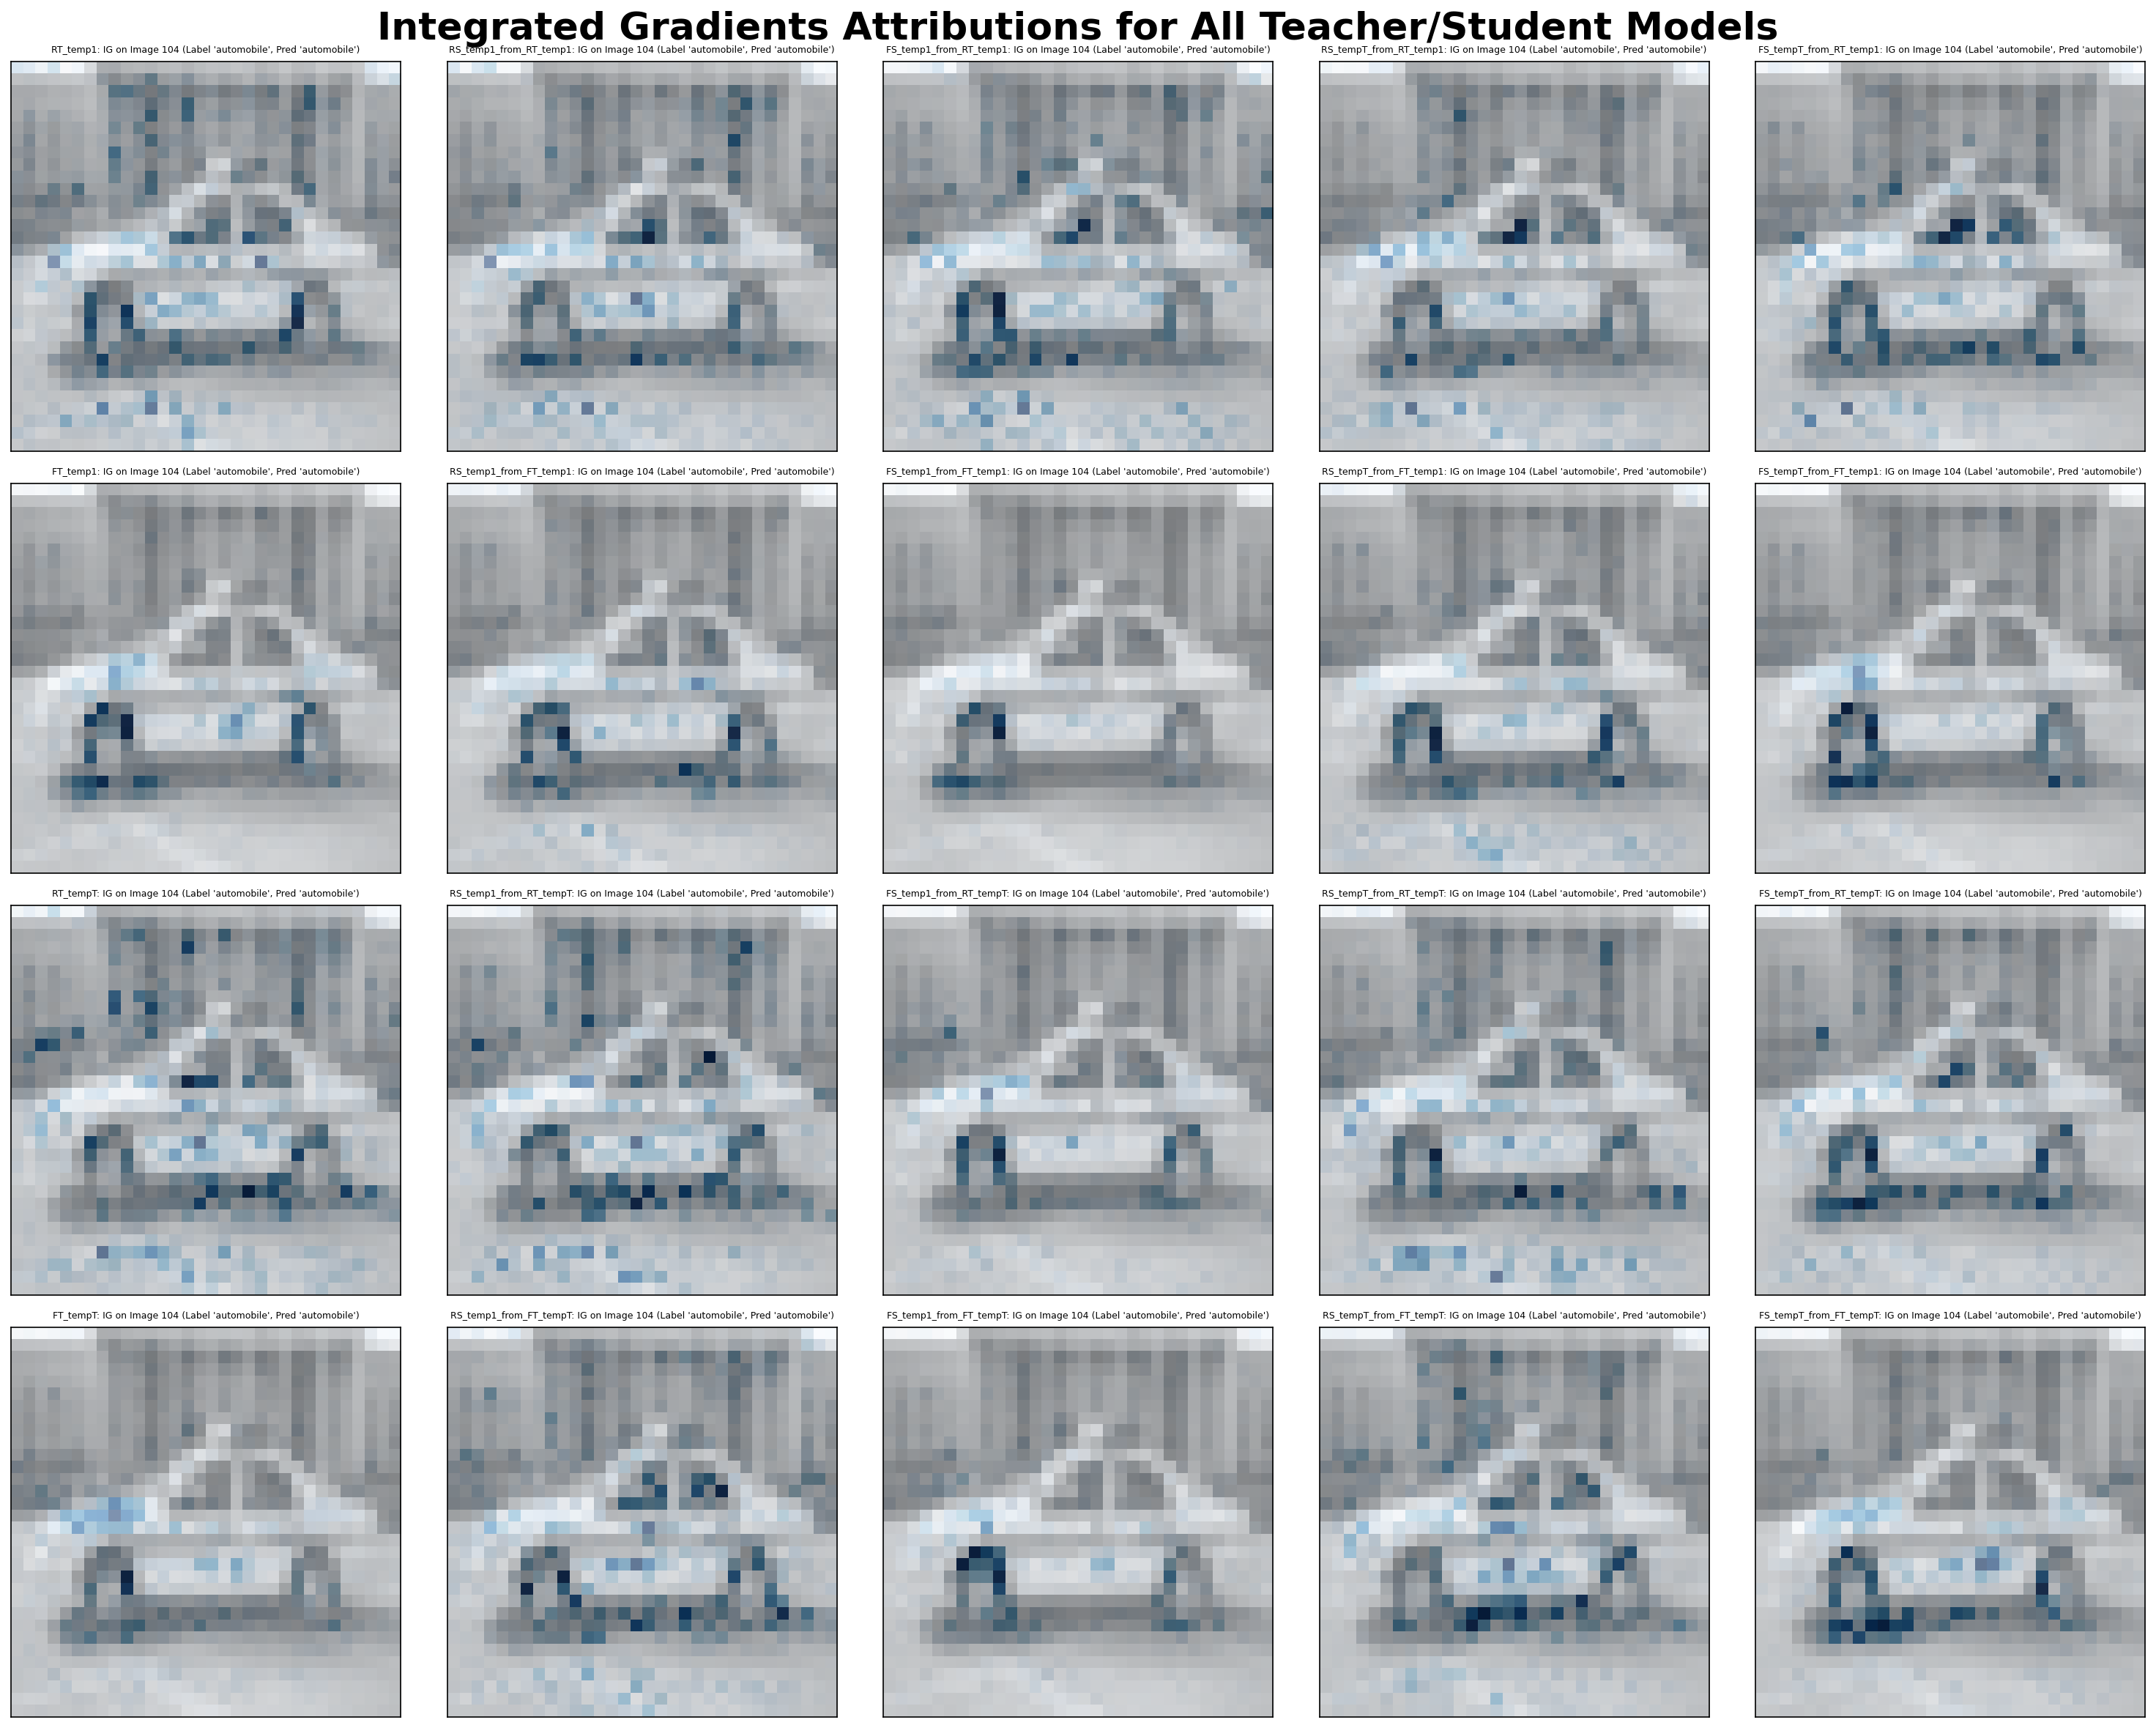

In [43]:
img_idx = 104
method = IntegratedGradients
dataloader = testloader
just_relevant = False

# create subplots
num_cols = 5
num_rows = 4
fig, ax = plt.subplots(4, 5, figsize=(4*num_cols,4*num_rows))

# populate subplots
for row, (teacher, students) in enumerate(TEACHER_TO_STUDENTS.items()):
    # first plot teacher model
    plot_attribution_on_ax(ax[row][0], teacher, method, img_idx, dataloader, just_relevant)

    # iterate through students and plot
    for col, student in enumerate(students):
        plot_attribution_on_ax(ax[row][col+1], student, method, img_idx, dataloader, just_relevant)
    
# superplot configurations
fig.suptitle(f"{method_to_name[method]} Attributions for All Teacher/Student Models", fontsize=25, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f"{method_to_name_reduced[method]}_img{img_idx}_ALL.png"))
plt.show()